In [1]:
import matplotlib.pyplot as plt
import numpy as np
import umap
import imageio
import os
from tqdm import trange
from sklearn.manifold import TSNE

(10.0, 79.0)

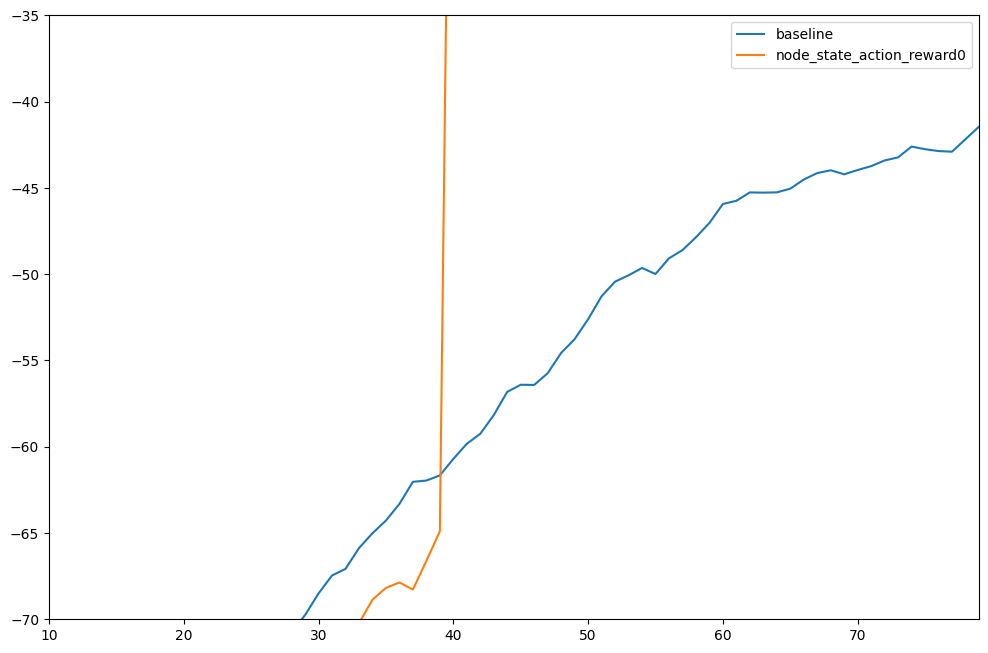

In [2]:
fig = plt.figure(figsize=(12, 8), dpi=100)
plt.plot(np.load('ppo_bline_baseline.npy'), label="baseline")
#plt.plot(np.load('node_priv_unk_lstm0.npy'), label="loss fix0")
#plt.plot(np.load('node_priv_unk_lstm1.npy'), label="loss fix1")
#plt.plot(np.load('node_priv_unk_lstm2.npy'), label="loss fix2")
#plt.plot(np.load('node_priv_unk_lstm3.npy'), label="loss fix3")

plt.plot(np.load('node_validation_feedforward0.npy'), label="node_state_action_reward0")
#plt.plot(np.load('node_validation1.npy'), label="node_state_action_reward1")
#plt.plot(np.load('node_validation2.npy'), label="node_state_action_reward2")
#plt.plot(np.load('node_validation3.npy'), label="node_state_action_reward3")

#plt.plot(np.load('node_state_action_reward3.npy'), label="node_state_action_reward3")
#plt.plot(np.load('node_priv_unk_lstm5.npy'), label="loss fix5")
#plt.plot(np.load('node_priv_unk_lstm6.npy'), label="loss fix6")

plt.legend()

plt.ylim(-70, -35)
plt.xlim(10, 79)

In [566]:
mean_ = []
mean_.append(np.load('node_with_priv0.npy'))
mean_.append(np.load('node_with_priv1.npy'))
mean_.append(np.load('node_with_priv2.npy'))
mean_.append(np.load('node_with_priv3.npy'))
mean_ = np.array(mean_)
mean_ = np.mean(mean_, axis=1)
mean_

array([-85.05016167, -84.95676583, -86.28819833, -84.46672333])

In [662]:
from os import listdir
from os.path import isfile, join
path = '/home/adamprice/u75a-Data-Efficient-Decisions/CybORG/CybORG/MBPPO/batch_encodings/'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
batches = {}
for f in onlyfiles:
    index = int(f.split('_')[-1].split('.')[0])
    if f.split('_')[0] == 'dream': index += 1
    batches[index] = np.load(path + f)

keys = list(batches.keys())
keys.sort()
batches = {i: batches[i] for i in keys}

real_map = []; dream_map = []
for i, k in enumerate(list(batches.keys())):
    if k % 2 == 0:
        real_map.append(i)
    else:
        dream_map.append(i)
batch_array = np.array((list(batches.values())))

real_map_array = np.array(real_map, dtype=np.int16)
dream_map_array = np.array(dream_map, dtype=np.int16)

In [582]:
batch_array.shape

(180, 91)

In [663]:
#reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
#embedding = reducer.fit_transform(batch_array)
embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(batch_array[:120,:])

In [744]:
print('Spread from Real:')
cate = ['exploit', 'scan', 'no_activity', 'privileged', 'user', 'unknown', 'no comp']
for i in range(7):
    print(cate[i], np.mean(np.abs(batch_array[100][np.arange(i,91,step=7)])))


Spread from Real:
exploit 0.015524475524475527
scan 0.052517482517482526
no_activity 0.931958041958042
privileged 0.0012587412587412587
user 0.01951048951048951
unknown 0.011888111888111888
no comp 0.9673426573426573


In [747]:
print('Spread from Dream:')
cate = ['exploit', 'scan', 'no_activity', 'privileged', 'user', 'unknown', 'no comp']
for i in range(7):
    print(cate[i], np.mean(np.abs(batch_array[105][np.arange(i,91,step=7)])))

Spread from Dream:
exploit 0.025538462138054177
scan 0.048615384560364946
no_activity 0.9258461548731878
privileged 0.004999999879286266
user 0.05080769268366007
unknown 0.06861538611925565
no comp 0.8755769248192127


In [469]:
np.set_printoptions(suppress=True)


In [664]:

path = 'gagif'
if not os.path.exists('gagif'):
    os.mkdir(path)
#Comment out umap_embedding if adjusting plots after first run, its non-determeisitic 

obs_based_reward = np.load('node_priv_unk_lstm0.npy')

dream_pnt = 0; real_pnt = 0
filenames = []
for i in trange(120):#batch_array.shape[0]): 
    fig = plt.figure(figsize=(12, 8), dpi=100)
    
    ax = plt.subplot(1, 2, 1)
    ax.set_xlim([embedding[:,0].min()-2,embedding[:,0].max()+2])
    ax.set_ylim([embedding[:,1].min()-2,embedding[:,1].max()+2]) 
    ax.set_title('t-SNE plot of Batch Observation Embedding')
    ax1 = plt.subplot(1, 2, 2)
    ax1.set_xlim([0,80])
    ax1.set_ylim([-80,-35])
    ax1.set_title('Reward Accumilation')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Reward')
    ax1.plot(obs_based_reward[:real_pnt], label="Node Based")
    plt.plot(np.load('ppo_bline_baseline.npy'), label="Model Free Baseline")
    #ax1.plot(evals_ppo[:i_line+1], label="PPO - Evaluation")
    ax1.legend(loc='lower right')

    if i in real_map:
        real_pnt += 1
    else:
        dream_pnt += 1

    ax.scatter(embedding[real_map_array[:real_pnt]][:,0], embedding[real_map_array[:real_pnt]][:,1], alpha=0.5, label = 'Real')
    ax.scatter(embedding[dream_map_array[:dream_pnt]][:,0], embedding[dream_map_array[:dream_pnt]][:,1], alpha=0.5, label = 'Dream')
    ax.legend()
    plt.savefig(path+'/'+str(i)+'.png')
    filenames.append(path+'/'+str(i)+'.png')
    plt.close()

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('worldmodel_training.gif', images, duration=0.2)

100%|██████████| 120/120 [00:47<00:00,  2.53it/s]


In [451]:
imageio.mimsave('worldmodel_training.gif', images, duration=0.3)

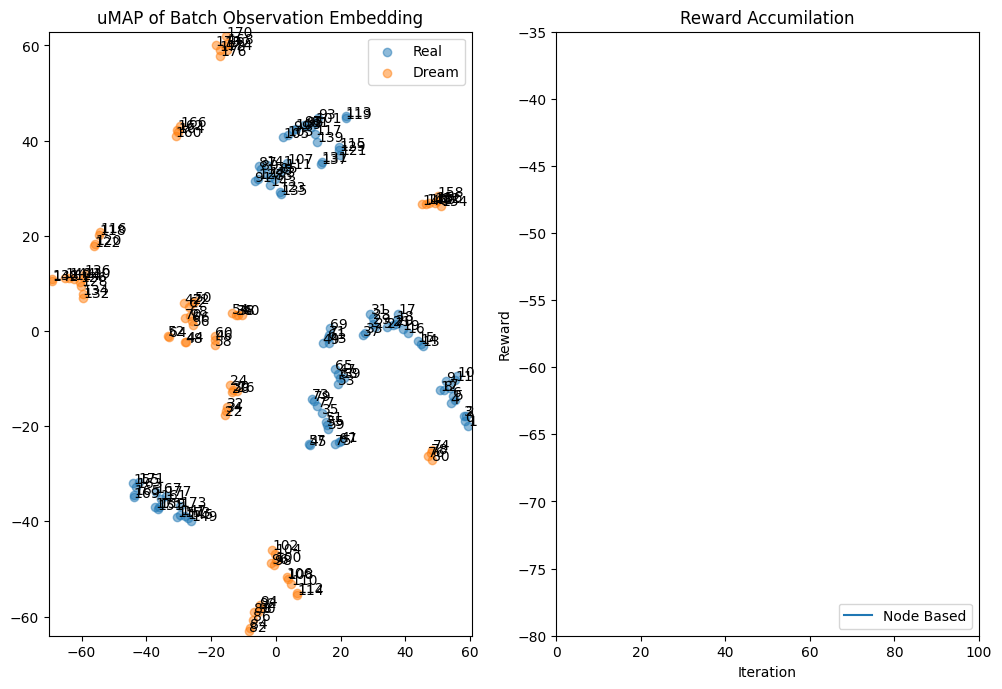

In [354]:

path = 'gagif'
if not os.path.exists('gagif'):
    os.mkdir(path)
#Comment out umap_embedding if adjusting plots after first run, its non-determeisitic 

obs_based_reward = np.load('ppo_lstm1.npy')

dream_pnt = 0; real_pnt = 0
filenames = []
fig = plt.figure(figsize=(12, 8), dpi=100)

ax = plt.subplot(1, 2, 1)
ax.set_xlim([embedding[:,0].min()-2,embedding[:,0].max()+2])
ax.set_ylim([embedding[:,1].min()-2,embedding[:,1].max()+2]) 
ax.set_title('uMAP of Batch Observation Embedding')
ax1 = plt.subplot(1, 2, 2)
ax1.set_xlim([0,80])
ax1.set_ylim([-80,-35])
ax1.set_title('Reward Accumilation')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Reward')
ax1.plot(obs_based_reward[:real_pnt], label="Node Based")
#ax1.plot(evals_ppo[:i_line+1], label="PPO - Evaluation")
ax1.legend(loc='lower right')


ax.scatter(embedding[real_map_array][:,0], embedding[real_map_array][:,1], alpha=0.5, label = 'Real')
ax.scatter(embedding[dream_map_array][:,0], embedding[dream_map_array][:,1], alpha=0.5, label = 'Dream')
ax.set_xlim([np.min(embedding[:,0])-1,np.max(embedding[:,0])+1])
ax.set_ylim([np.min(embedding[:,1])-1,np.max(embedding[:,1])+1])
ax.legend()

for i, txt in enumerate(dream_map_array):
    ax.annotate(txt, (embedding[dream_map_array][i,0], embedding[dream_map_array][i,1]))

for i, txt in enumerate(real_map_array):
    ax.annotate(txt, (embedding[real_map_array][i,0], embedding[real_map_array][i,1]))


In [88]:
np.arange(4,91,step=7)

array([ 4, 11, 18, 25, 32, 39, 46, 53, 60, 67, 74, 81, 88])

In [207]:
from ray.rllib.utils.replay_buffers import ReplayBuffer, StorageUnit 
from ray.rllib.policy.sample_batch import SampleBatch 

buffer = ReplayBuffer(capacity=100)
dummy_batch = SampleBatch({"a": np.arange(100)})
buffer.add(dummy_batch)
s = buffer.sample(100)['a']
s
#for i in range(100):
#    print(np.where(s==i))

array([93, 19,  4, 92, 20, 81, 42, 21, 70, 51, 35,  6, 26, 37, 33, 93, 33,
       77, 80,  7, 27, 46, 23, 47, 59, 57, 26, 57, 31, 77,  7, 67,  9, 20,
       21, 94, 99, 73, 35, 25, 66, 13, 91, 31, 62, 23, 47, 98, 71, 68, 55,
       20, 80,  3, 60, 31,  5, 29, 24, 86, 71, 14, 36, 57, 34, 23, 53, 19,
       38, 62, 34, 68,  3, 23, 18, 92, 73,  4, 31,  6, 47, 60, 97, 35, 87,
        0, 13, 80, 94, 85,  4, 44,  3, 86,  1,  1, 58, 62,  7, 13])

In [273]:
def node_action(action, node):
    vec = np.zeros(3)
    if action < 2: 
        return vec
    action -= 2
    if action % 13 == node:
        #Analyse #Remove #Resotre
        vec[int(action) // 13] = 1
    return vec

for i in range(41):
    for k in range(13):
        print(node_action(k,i))

[0. 0. 0.]
[0. 0. 0.]
[1. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[1. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[1. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[1. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[1. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[1. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[1. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]